In [6]:
# To run this notebook in Google Colab, uncomment the following line to
# install all required packages.
#!pip install git+https://github.com/simonpf/at652

# Practical example 2: Using a U-net to retrieve precipitation

- This notebook demonstrates how to train a U-net model on the IPWG Satellite Precipitation Retrieval (SPR) dataset to predict surface precipitation rates from passive microwave satellite observations.

> Note: This notebook does assume that you have a GPU available on the machine you are running it on. Feel free to adapt the code to run on CPU but the training will likely be excruciatingly slow.

### Getting and loading the data
 - In addition to the tabular training data used in the MLP example, the IPWG SPR dataset also provides training, validation, and test data in image format.
 - These can be downloaded by choosing the spatial format
 > Note: The spatial training datasets are fairly large so the download may take a while.

In [7]:
import ipwgml
from ipwgml.data import download_dataset
import xarray as xr

training_files = download_dataset("spr", "gmi", "gmi", "training", "on_swath", "spatial")
gmi_files_training = training_files["gmi"]
target_files_training = training_files["target"]
validation_files = download_dataset("spr", "gmi", "gmi", "validation", "on_swath", "spatial")
gmi_files_validation = validation_files["gmi"]
target_files_validation = validation_files["target"]

## Calculating observation statistics

- We begin by calculating the minimum and maximum of the GMI brightness temperatures, which we need for normalizing the input.

In [8]:
import numpy as np
from tqdm import tqdm

max_tbs = np.zeros(13)
min_tbs = 1000 * np.ones(13)

for path in tqdm(gmi_files_training):
    with xr.open_dataset(path, engine="h5netcdf") as data:
        obs = data.observations.data
        max_tbs = np.maximum(max_tbs, np.nanmax(obs, axis=(0, 1)))
        min_tbs = np.minimum(min_tbs, np.nanmin(obs, axis=(0, 1)))

MAX_TBS = max_tbs
MIN_TBS = min_tbs

100%|██████████████████████████████████████████████████████████████████████████████████| 44703/44703 [07:21<00:00, 101.14it/s]


## A dataset class for the training scenes

- Below we define a dataset class to load the training data
- The spatial IPWG SPR training data is stored in individual scenes in NetCDF format

In [111]:
import os

from pathlib import Path
from typing import List
import torch
from torch.utils.data import Dataset

class IPWGSPRDataset(Dataset):
    """
    Dataset class to load IPWG SPR data in spatial format.

    The dataset class loads the image and corresponding surface precipitation.
    Surface precipitation values with low radar-quality index are set to NAN.
    Random horizontal and vertical flips are applied to augment the training data.  
    """
    def __init__(
        self,
        gmi_files: List[Path],
        target_files: List[Path],
        validation: bool = False,
        rqi_threshold: float = 0.8
    ):
        """
        Args:
            gmi_files: A list containing the GMI input data files.
            target_files: A list containing the reference data files.
            validation: If 'True', no random flips are applied.
            rqi_threshold: Surface precipitation estimates with a RQI below this threshold 
                will be masked.
        """
        self.gmi_files = np.array(gmi_files)
        self.target_files = np.array(target_files)
        self.validation = validation
        self.rqi_threshold = rqi_threshold
        self.worker_init_fn(0)

    def worker_init_fn(self, w_id: int = 0) -> None:
        """
        Initialize random number generator. This function is called by the
        PyTorch data loader to ensure that different processes generate independent
        random numbers.

        Args:
            w_id: The worker ID which of the worker process..
        """
        if self.validation:
            seed = 42
        else:
            seed = int.from_bytes(os.urandom(4), "big") + w_id

        self.rng = np.random.default_rng(seed)

    def __len__(self) -> int:
        """
        The number of samples in the dataset.    
        """
        return len(self.gmi_files)

    def __getitem__(self, index: int):
        """
        Load the sample with the given index.

        Args:
            index: The index of the sample to load.

        Return:
            A tuple ``(x, y)`` containing the retrieval input data and reference
            data as rank-3 ([channel, height, width]) torch tensors.
        """
        gmi_file = self.gmi_files[index]
        target_file = self.target_files[index]

        with xr.open_dataset(gmi_file) as data:
            obs = data.observations.data
            obs = -1.0  + (obs - MIN_TBS) / (MAX_TBS - MIN_TBS)
            obs = np.nan_to_num(obs, nan=-1.5)
            # Bring channels to the front.
            obs = np.transpose(obs, (2, 0, 1))
            
        with xr.open_dataset(target_file) as data:
            surface_precip = data.surface_precip.data
            rqi = data.radar_quality_index.data

        valid = rqi > self.rqi_threshold

        # Fall back to random scene if it contains no valid reference data.
        if valid.sum() == 0:
            return self[self.rng.integers(0, len(self))]

        surface_precip[valid] = np.nan

        obs = torch.tensor(obs.astype("float32"))
        surface_precip = torch.tensor(surface_precip.astype("float32"))[None]

        if not self.validation:
            prob = self.rng.random()
            if prob > 0.5:
                obs = torch.flip(obs, (-2,))
                surface_precip = torch.flip(surface_precip, (-2,))
            prob = self.rng.random()
            if prob > 0.5:
                obs = torch.flip(obs, (-1,))
                surface_precip = torch.flip(surface_precip, (-1,))

        return obs, surface_precip

In [38]:
training_data = IPWGSPRDataset(gmi_files_training, target_files_training, False)
validation_data = IPWGSPRDataset(gmi_files_validation, target_files_validation, True)

## The U-net model

- Below we build a UNet model from scratch.
- The basic UNet or encoder-decoder architecture consists of an encoder that incrementally downsamples the image size to extract increasingly higher-level features from the input data. The decoder upsamples these features back to the input size. The outputs from each encoder stage are appended to the inputs of each corresponding decoder stage forming short cuts between model input and output. These are called skip connections.

The seminal paper introducing U-net is the following:

Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18. Springer International Publishing, 2015.

### Basic building blocks

- Each stage of the encoder and decoder are constructed using the same convolution blocks. Here we use ResNet-type blocks. ResNet introduced residual connections that directly connect the input of each block to its output. Residual connections and batch normalization the key innovations that enabled the training of very deep neural networks (100s of layers instead of 10s of layers).

In [113]:
from torch import nn

class ResidualConvBlock(nn.Module):
    """
    A ResNet-type convolutional block consisting of two convolution layers each
    followed by batch normalization and ReLU activation function and a skip connection
    connecting input and output of the block.

    If requested, this block also performs downsampling using max-pooling.
    """
    def __init__(
        self,
        n_chans_in: int,
        n_chans_out: int,
        downsample: int = 1
    ):
        """
        Args:
            n_chans_in: The number of channels in the block input.
            n_chans_out: The number of channels in the block output.
            downsample: The downsampling to apply to the input.
        """
        super().__init__()
        blocks = []
        if downsample > 1:
            blocks.append(nn.MaxPool2d(kernel_size=downsample, stride=downsample))
        blocks += [
            nn.Conv2d(n_chans_in, n_chans_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_chans_out),
            nn.ReLU(),
            nn.Conv2d(n_chans_out, n_chans_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_chans_out),
            nn.ReLU()
        ]
        self.body = nn.Sequential(*blocks)
        
        blocks = []
        if downsample > 1:
            blocks.append(nn.AvgPool2d(kernel_size=downsample, stride=downsample))
        if n_chans_in != n_chans_out:
            blocks.append(
                nn.Conv2d(n_chans_in, n_chans_out, kernel_size=1)
            )
        self.projection = nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagate input through block.
        """
        y = self.body(x)
        return y + self.projection(x)
    

In [115]:
### U-net implementation

- We keep U-net implementation fairly straight forward.
- We use nn.ModuleLists to store the stages of the encoder and decoder.
- When we propagate through the encoder we create a list of the outputs from each stage for implement the skip connections
- When propagating through the decoder we concatenate the upsampled decoder input with the corresonding encoder output from the  skip connection
- We also add a stem (input layer) and head (output layer) consisting of pixel-wise affine transformations.


In [114]:
class UNet(nn.Module):
    """
    Basic U-net implementation with ResNet blocks.
    """
    def __init__(
        self,
        n_input_channels,
        channels
    ):
        """
        Create a U-net with expecting input with 'n_input_channels' and a given
        number of channels within its internal layers. Each stage of this U-net consists
        of two ResidualConvBloack, each consisting of 2 2D convolution layers followed
        by batch normalization and ReLU activation function. Additionally, the U-net adds
        a linear input layer (stem) and output layer (head).

        Args:
            n_input_channels: The number of channes in the input.
            channels: A list of the channels of each stage in the encoder followed
                by those in the decoder.
        """
        super().__init__()
        channels_encoder = channels[:len(channels) // 2]
        channels_decoder = channels[len(channels) // 2:]

        self.stem = nn.Conv2d(n_input_channels, channels[0], kernel_size=3, padding=1)

        skip_channels = []
        chans_in = channels[0]
        encoder_stages = []
        for chans_out in channels_encoder:
            encoder_stages.append(
                nn.Sequential(
                    ResidualConvBlock(chans_in, chans_out, downsample=2),
                    ResidualConvBlock(chans_out, chans_out),
                )
            )
            chans_in = chans_out
        self.encoder_stages = nn.ModuleList(encoder_stages)

        channels_skip = channels_encoder[-2::-1] + [channels[0]]
        decoder_stages = []
        for chans_out, chans_skip in zip(channels_decoder, channels_skip):
            decoder_stages.append(
                nn.Sequential(
                    ResidualConvBlock(chans_in + chans_skip, chans_out),
                    ResidualConvBlock(chans_out, chans_out),
                )
            )
            chans_in = chans_out
        self.decoder_stages = nn.ModuleList(decoder_stages)
        self.upsampler = nn.Upsample(scale_factor=2, mode="bilinear")
        self.output_layer = nn.Conv2d(chans_out, 1, kernel_size=1)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagate a tensor through the U-net.
        """
        x = self.stem(x)
        
        # Propagate through encoder.
        skips = []
        for stage in self.encoder_stages:
            skips.append(x)
            x = stage(x)

        # Propagate through decoder.
        skips.reverse()
        for stage, skip in zip(self.decoder_stages, skips):
            x = self.upsampler(x)
            x = stage(torch.cat([x, skip], 1))

        return self.output_layer(x)


In [105]:
from torch import nn
import lightning as lit

class LightningModule(lit.LightningModule):
    """
    A lightning module defines how to evaluate the training and validation losses of our
    neural network models, and the setup of the optimizer. This is sufficient to leave all
    other details of the training to Pytorch lightning.
    """
    def __init__(
        self,
        model,
        loss_fn = nn.MSELoss(),
        optim = torch.optim.SGD,
        lr_scheduler = None,
        lr=1e-3
    ):
        """
        Create the lightning module.

        Args:
            model: The nn.Module to train
            loss_fn: A PyTorch callable defining the loss function
            optim: The optimizer class to use for optimization.
            lr_scheduler: An optional learning-rate scheduler.
            lr: The inital learning rate.
        """
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.optim = optim
        self.lr_scheduler = lr_scheduler
        self.lr = lr

    def forward(self, x):
        """
        Propage tensor through model.
        """
        return self.model(x)

    def training_step(self, batch, *args):
        """
        Calculate loss for a single training step.
        """
        x, y = batch
        y_pred = self(x)
        valid = torch.isfinite(y)
        loss = self.loss_fn(y[valid], y_pred[valid])
        self.log("Training loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, *args):
        """
        Calculate loss for a single validation step.
        """
        x, y = batch
        y_pred = self(x)
        valid = torch.isfinite(y)
        loss = self.loss_fn(y_pred[valid], y[valid])
        self.log("Validation loss", loss, prog_bar=True)

    def configure_optimizers(self):
        """
        Configure optimizer and scheduler for the training.
        """
        optim = self.optim(self.parameters(), self.lr)
        config = {"optimizer": optim}
        if self.lr_scheduler is not None:
            config["lr_scheduler"] = self.lr_scheduler(optim)
        return config


In [ ]:
### The training

In [107]:
from functools import partial
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# We create a U-net with 13 input channels and gradually increasing number of
# channels in its internal layers.
unet = UNet(13, [64, 128, 256, 512, 256, 128, 64])
lit_module = LightningModule(
    unet,
    optim=Adam,
    lr_scheduler=partial(CosineAnnealingLR, T_max=40),
    lr=5e-4
)
trainer = lit.Trainer(accelerator="cuda", devices=[0], max_epochs=40)

INFO: GPU available: True (cuda), used: True


[10/31/24 06:43:01] INFO     INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), ]8;id=79659;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=802256;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             used: True                                                                            

INFO: TPU available: False, using: 0 TPU cores


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:TPU available: False,       ]8;id=790086;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=782679;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 TPU cores                                                                    

INFO: HPU available: False, using: 0 HPUs


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:HPU available: False,       ]8;id=987217;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=476413;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 HPUs                                                                         

In [108]:
from torch.utils.data import DataLoader
train_loader = DataLoader(training_data, batch_size=32, num_workers=8, worker_init_fn=training_data.worker_init_fn)
val_loader = DataLoader(validation_data, batch_size=32, num_workers=8, worker_init_fn=validation_data.worker_init_fn)

In [110]:
trainer.fit(lit_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


[10/31/24 06:43:16] INFO     INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 -                    ]8;id=102541;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=906587;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\
                             CUDA_VISIBLE_DEVICES: [0,1,2,3]                                                       

INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | UNet    | 15.9 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
15.9 M    Trainable params
0         Non-trainable params
15.9 M    Total params
63.736    Total estimated model params size (MB)
132       Modules in train mode
0         Modules in eval mode


                    INFO     INFO:lightning.pytorch.callbacks.model_summary:                   ]8;id=314076;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=993838;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
                               | Name    | Type    | Params | Mode                                                 
                             --------------------------------------------                                          
                             0 | model   | UNet    | 15.9 M | train                                                
                             1 | loss_fn | MSELoss | 0      | train                                                
                             --------------------------------------------                                          
                             15.9 M    Trainable params                                                            
                             0         Non-trainable params                                                        
                             15.9 M    Total params                                                                
                             63.736    Total estimated model params size (MB)                                      
                             132       Modules in train mode                                                       
                             0         Modules in eval mode                                                        

Sanity Checking: |                                                                                      | 0/? …

Training: |                                                                                             | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

INFO: `Trainer.fit` stopped: `max_epochs=40` reached.


[10/31/24 07:49:30] INFO     INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped:      ]8;id=168472;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=781945;file:///gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             `max_epochs=40` reached.                                                              

### Saving the model state

- We save the model state (which contains all weights) so that we can load it later.

In [60]:
unet_state = unet.state_dict()
torch.save(unet_state, "unet.pt")

## Evaluation

- For the evaluation we need to slightly modify the retrieval callback to account for the different structure of the input and output data

> **IMPORTANT**: Since our model contains batch normalization layers, we need to put the model into evaluation mode. This is done be calling the model's ``eval`` function. This is extremely important because the model will likely perform a lot worse if we forget this.

In [118]:
from ipwgml.evaluation import Evaluator

class RetrievalCallback:
    """
    A callable that run the given PyTorch model on IPWGML
    retrieval test data.
    """
    def __init__(self, model: nn.Module):
        """
        Args:
            model: The trained PyTorch model implemented the retrieval.
        """
        self.model = model.to(device=torch.device("cuda:0")).eval()
        
    def __call__(self, input_data: xr.Dataset) -> xr.Dataset:
    
        input_data = input_data.transpose("batch", "channels_gmi", "scan", "pixel")

        # Don't forget to normalize your input data in the exact same
        # way during inference as during training
        obs = input_data.obs_gmi.data
        obs_n = -1.0 +(obs - MIN_TBS[..., None, None]) / (MAX_TBS - MIN_TBS)[..., None, None]
        obs = torch.nan_to_num(torch.tensor(obs_n).to(torch.float32), nan=-1.5)
        obs = obs.to(device=torch.device("cuda:0"))

        with torch.no_grad():
            surface_precip = self.model(obs).cpu().numpy()
    
        return xr.Dataset({
            "surface_precip": (("batch", "scan", "pixel",), surface_precip[:, 0])
        })

retrieval_fn = RetrievalCallback(unet)

In [119]:
### Case study

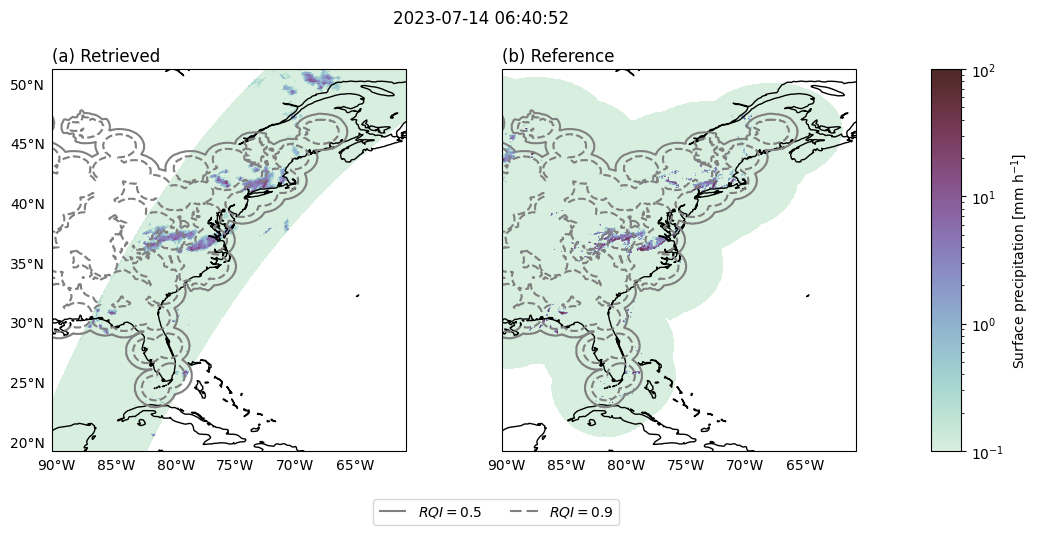

In [125]:
evaluator = Evaluator(
    reference_sensor="gmi",
    geometry="on_swath",
    retrieval_input=["gmi"],
)
evaluator.plot_retrieval_results(
    scene_index=86,
    retrieval_fn=retrieval_fn,
    input_data_format="spatial",
    tile_size=64,
    batch_size=32
);

In [131]:
from ipwgml.target import TargetConfig
tconf = TargetConfig(min_rqi=0.8)
evaluator = Evaluator(
    reference_sensor="gmi",
    geometry="on_swath",
    retrieval_input=["gmi"],
    target_config=tconf
)
evaluator.evaluate(
    retrieval_fn=retrieval_fn, 
    input_data_format="spatial",
    batch_size=32,
    tile_size=64   
    
)

Output()

In [132]:
### Results

In [133]:
baseline_results = evaluator.get_precip_quantification_results(name="U-net")
baseline_results

/gdata1/simon/micromamba/envs/at652/lib/python3.11/site-packages/ipwgml/metrics.py:672: RuntimeWarning: divide by zero encountered in divide
  scales = 0.5 * (N - 1) * self.scale / n


,Bias [$\%$],MAE [$mm h^{-1}$],MSE [$(mm h^{-1})^2$],SMAPE$_{0.1}$ [$\%$],Correlation coeff. [],Effective resolution [$^\circ$]
U-net,-31.015199,0.127608,1.288456,90.913004,0.660080,0.279
IMERG Final V7 (GMI),-7.398772,0.124924,1.731411,114.417614,0.455411,inf
GPROF V7 (GMI),5.799770,0.119785,1.413339,91.327371,0.552348,0.423
